In [22]:
import pandas as pd
import numpy as np
data = pd.read_pickle('../data/processed/data.pkl')


In [23]:
# age / gender filter
age_filter = data.age >= 20
gender_filter = data.gender.notnull()
data = data.loc[age_filter & gender_filter]

In [24]:
len(data)

142016

In [25]:
# many missing columns
filter_notnull_column = (data.isnull().sum() /len(data) < 0.5).to_numpy()
data.columns[filter_notnull_column]

Index(['patientunitstayid', 'intubated', 'vent', 'dialysis', 'eyes', 'motor',
       'verbal', 'meds', 'urine', 'wbc', 'temperature', 'respiratoryrate',
       'sodium', 'heartrate', 'meanbp', 'hematocrit', 'creatinine', 'bun',
       'glucose', 'gender', 'age', 'admitdiagnosis', 'aids', 'hepaticfailure',
       'lymphoma', 'metastaticcancer', 'leukemia', 'immunosuppression',
       'cirrhosis', 'electivesurgery', 'activetx', 'readmit', 'diabetes',
       'actualicumortality', 'actualhospitalmortality', 'actualhospitallos'],
      dtype='object')

In [26]:
data = data.loc[:,filter_notnull_column].reset_index(drop = True)

In [27]:
def calculate_gcs(eyes, motor, verbal, meds):
    if meds == 1:
        return np.nan
    return eyes + motor + verbal

In [28]:
data.loc[:,'gcs'] = data.apply(lambda x: calculate_gcs(x['eyes'], x['motor'], x['verbal'], x['meds']), axis=1)
data.drop(['eyes', 'motor', 'verbal', 'meds'], axis=1, inplace=True)

In [29]:
gcs_filler = data['gcs'].mean().round()

In [30]:
median_filling_columns = ['urine', 'wbc', 'temperature', 'sodium', 'hematocrit', 'creatinine', 'bun', 'glucose', 'respiratoryrate', 'heartrate','meanbp']
median_int_filling_columns = ['gcs']

In [31]:
# split_train_test_dataset
from sklearn.model_selection import train_test_split
X_total = data.drop(['patientunitstayid','admitdiagnosis', 'actualicumortality', 'actualhospitalmortality', 'actualhospitallos'], axis=1)
y_total = data['actualicumortality']
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, stratify=y_total, test_size=0.20, random_state=2022)

In [32]:
# filling NA in train dataset
median_filler = X_train.loc[:,median_filling_columns].mean()
median_int_filler = X_train.loc[:,median_int_filling_columns].mean().round()
X_train.loc[:,median_filling_columns] = X_train.loc[:,median_filling_columns].fillna(median_filler)
X_train.loc[:,median_int_filling_columns] = X_train.loc[:,median_int_filling_columns].fillna(median_int_filler)

In [33]:
X_train

,intubated,vent,dialysis,urine,wbc,temperature,respiratoryrate,sodium,heartrate,meanbp,...,lymphoma,metastaticcancer,leukemia,immunosuppression,cirrhosis,electivesurgery,activetx,readmit,diabetes,gcs
21308,0,0,0,225.676800,12.273005,36.3000,11.0,137.923471,95.0,70.0,...,0,0,0,0,0,0,0,0,0,15.0
44993,0,1,0,1297.382400,11.920000,36.7000,12.0,142.000000,105.0,71.0,...,0,0,0,0,0,0,1,0,0,15.0
34712,0,0,0,1892.246400,7.800000,36.6000,11.0,144.000000,127.0,108.0,...,0,0,0,0,0,0,1,0,0,15.0
101732,0,0,0,1821.333058,11.220000,36.4000,7.0,138.000000,143.0,43.0,...,0,0,0,0,0,0,0,0,0,13.0
113051,0,0,0,817.171200,14.100000,36.9000,11.0,143.000000,44.0,113.0,...,0,0,0,0,0,0,0,0,0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54491,0,1,0,1821.333058,13.310000,36.4272,48.0,136.000000,56.0,123.0,...,0,0,0,0,0,1,1,0,0,15.0
141103,1,1,0,1832.544000,10.400000,36.3000,51.0,139.000000,104.0,69.0,...,0,0,0,0,0,0,1,0,0,13.0
121837,0,1,0,1188.086400,5.700000,36.5000,11.0,139.000000,105.0,140.0,...,0,0,0,0,0,0,1,0,0,12.0
54658,0,0,0,1821.333058,10.520000,36.4272,4.0,137.000000,60.0,55.0,...,0,0,0,0,0,0,0,0,0,15.0


In [34]:
median_filler

urine              1821.333058
wbc                  12.273005
temperature          36.427200
sodium              137.923471
hematocrit           32.606850
creatinine            1.567922
bun                  26.702392
glucose             164.354953
respiratoryrate      25.474811
heartrate           100.507724
meanbp               87.176268
dtype: float64

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)

In [36]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train_norm, y_train)

LogisticRegression()

In [37]:
X_test.loc[:,median_filling_columns] = X_test.loc[:,median_filling_columns].fillna(median_filler)
X_test.loc[:,median_int_filling_columns] = X_test.loc[:,median_int_filling_columns].fillna(median_int_filler)
X_test_norm = scaler.transform(X_test)
predictions = logmodel.predict(X_test_norm)
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     26784
           1       0.54      0.11      0.19      1620

    accuracy                           0.94     28404
   macro avg       0.75      0.55      0.58     28404
weighted avg       0.93      0.94      0.93     28404



In [38]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, logmodel.predict_proba(X_test_norm)[:,1])
fpr, tpr, thresholds

(array([0.00000000e+00, 0.00000000e+00, 3.73357228e-05, ...,
        9.70019415e-01, 9.70019415e-01, 1.00000000e+00]),
 array([0.00000000e+00, 6.17283951e-04, 6.17283951e-04, ...,
        9.99382716e-01, 1.00000000e+00, 1.00000000e+00]),
 array([1.94067839e+00, 9.40678386e-01, 9.25075042e-01, ...,
        2.09245105e-03, 2.09239641e-03, 5.50009432e-06]))

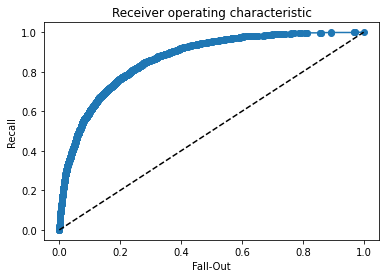

In [39]:
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, 'o-', label="Logistic Regression") # o for circle
plt.plot([0, 1], [0, 1], 'k--', label="random guess") # k for black
plt.xlabel('Fall-Out')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic')
plt.show()

In [40]:
from sklearn.metrics import auc
auc(fpr, tpr)

0.8671050157086597

In [41]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[26627,   157],
       [ 1434,   186]])

In [42]:
# feature importance
items = X_train.columns
odd_ratio = np.exp(logmodel.coef_)
pd.DataFrame({'items':items, 'OR':odd_ratio.squeeze()}).sort_values('OR', ascending=False)

,items,OR
24,activetx,1.549427
15,age,1.486242
8,heartrate,1.314785
6,respiratoryrate,1.272508
1,vent,1.233924
12,bun,1.166305
4,wbc,1.146167
19,metastaticcancer,1.127111
0,intubated,1.099702
11,creatinine,1.095025
